<a href="https://colab.research.google.com/github/arkadijshmelev/Passenger_Satisfaction/blob/master/Passenger_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Библиотеки

In [26]:
!pip install xgboost catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from catboost import Pool, CatBoostClassifier
from catboost.utils import get_confusion_matrix

In [28]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Данные

In [29]:
# Загрузим данные с google drive.
data = drive.CreateFile({'id': '1ecqoV3EOONega5HJC99KqbJae3KyyChM'})
data.GetContentFile('AirPass.csv')

In [30]:
# Загрузим файл.
df = pd.read_csv('AirPass.csv')
# Удалим ненужный столбец.
df = df.drop('Unnamed: 0', axis=1)
# Выведем для просмотра.
display(df.head())
# Выведем информацию.
print(df.info())

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     1039

## Признаки

- Gender — пол пассажира (женский, мужской);
- Customer Type — тип клиента (постоянный/непостоянный клиент);
- Age — возраст клиента;
- Type of Travel — цель перелета (личная/деловая поездка);
- Class — туристический класс пассажира (Business, Eco, Eco Plus);
- Flight distance — расстояние полета;
- Inflight wifi service — уровень удовлетворённости Wi-Fi (0 — не применимо, 1–5);
- Departure/Arrival time convenient — уровень удовлетворённости временем отправления и прибытия;
- Ease of Online booking — уровень удовлетворённости онлайн-бронированием;
- Gate location — уровень удовлетворённости расположением выхода на посадку;
- Food and drink — уровень удовлетворённости едой и напитками;
- Online boarding — уровень удовлетворённости онлайн-регистрацией;
- Seat comfort — уровень удовлетворённости комфортом сидений;
- Inflight entertainment — уровень удовлетворённости развлечениями на борту;
- On-board service — уровень удовлетворённости сервисом на борту;
- Leg room service — уровень удовлетворённости местом для ног;
- Baggage handling — уровень удовлетворённости обработкой багажа;
- Check-in service — уровень удовлетворённости услугами регистрации;
- Inflight service — уровень удовлетворённости обслуживанием во время полёта;
- Cleanliness — уровень удовлетворённости чистотой;
- Departure Delay in Minutes — задержка при отправлении (в минутах);
- Arrival Delay in Minutes — задержка при прибытии (в минутах);
- Satisfaction — удовлетворённость авиакомпанией — целевая переменная (satisfaction/neutral/dissatisfaction).

In [31]:
# Выведем количество пропущенных значений в данных.
df.isnull().sum().sum()

310

In [32]:
# Выведем в каких признаках пропуски.
df.isnull().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [33]:
# Заменим пропуски на медианные значения.
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median())

## Разведывательный анализ

In [34]:
# Посмотрим, в каких категориях пассажиров превалировали удовлетворённые полетом клиенты.
df_1 = df.groupby('Gender')['satisfaction'].value_counts()*100/df.shape[0]
display(df_1)

Gender  satisfaction           
Female  neutral or dissatisfied    29.058554
        satisfied                  21.687327
Male    neutral or dissatisfied    27.608177
        satisfied                  21.645942
Name: satisfaction, dtype: float64

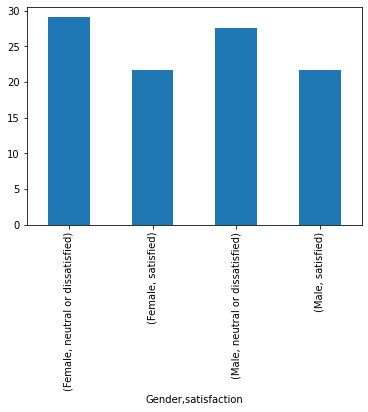

In [35]:
df_1.plot(kind='bar');

В обеих категориях больше нейтрально настроенных/недовольных.

In [36]:
# Сравним категории пассажиров в зависимости от их цели поездки.
df_2 = df.groupby('Type of Travel')['satisfaction'].value_counts()*100/df.shape[0]
display(df_2)

Type of Travel   satisfaction           
Business travel  satisfied                  40.177472
                 neutral or dissatisfied    28.785225
Personal Travel  neutral or dissatisfied    27.881506
                 satisfied                   3.155798
Name: satisfaction, dtype: float64

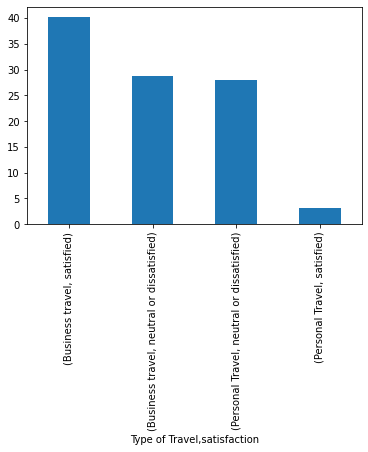

In [37]:
df_2.plot(kind='bar');

Среди тех, кто летал в деловую поездку, довольных больше, чем нейтрально настроенных/недовольных.

Среди тех, кто летал по личным делам, довольных меньше, чем нейтрально настроенных/недовольных.

In [38]:
# Найдем в каком туристическом классе наибольший процент довольных клиентов.
df_3 = df.groupby('Class')['satisfaction'].value_counts()*100/df.shape[0]
display(df_3)

Class     satisfaction           
Business  satisfied                  33.184478
          neutral or dissatisfied    14.614452
Eco       neutral or dissatisfied    36.614567
          satisfied                   8.374076
Eco Plus  neutral or dissatisfied     5.437712
          satisfied                   1.774715
Name: satisfaction, dtype: float64

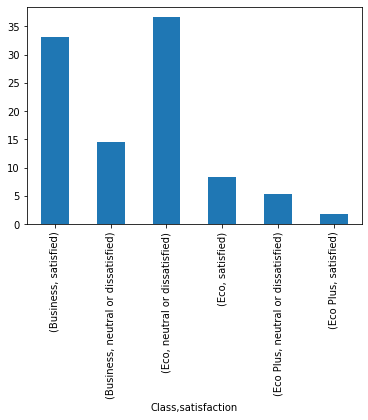

In [39]:
df_3.plot(kind='bar');

В Business-классе больший процент довольных полетом.

In [40]:
# Перекодируем часть бинарных признаков, чтобы использовать их при обучении.
df['satisfaction'] = df['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
df['Type of Travel'] = df['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [41]:
# Закодируем остальные категориальные признаки.
df = pd.get_dummies(df)
# Выведем размер датафрейма.
print(df.shape)

(103904, 26)


## Создание и обучение моделей

In [42]:
# Создадим матрицу наблюдений.
X = df.drop('satisfaction', axis=1)
# Создадим вектор правильных ответов.
y = df['satisfaction']

In [43]:
# Рзаобьем данные на тренировочную и тестовую выборки.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

In [44]:
# Создадим модель типа StandardScaler().
model_scaler = preprocessing.StandardScaler()
# Обучим модель на тренировочной выборке.
model_scaler.fit(X_train)
# Отмаштабируем данные.
X_train_scaler = model_scaler.transform(X_train)
X_test_scaler = model_scaler.transform(X_test)

In [45]:
# Иницианализируем модель логистической регрессии.
ln_model = linear_model.LogisticRegression()
# Обучим модель.
ln_model.fit(X_train_scaler, y_train)
# Сделаем предсказание.
y_test_pred = ln_model.predict(X_test_scaler)
# Выведем метрику.
print('f1_score : {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score : 0.855


In [46]:
# Создадим модель типа AdaBoostRegressor.
ad_model = ensemble.AdaBoostClassifier(
    tree.DecisionTreeClassifier(random_state=26),
    random_state=26,
    learning_rate=0.01
  )
# Обучим модель.
ad_model.fit(X_train_scaler, y_train)
# Сделаем предсказание.
y_test_pred = ad_model.predict(X_test_scaler)
# Выведем метрику.
print('f1_score : {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score : 0.940


In [47]:
# Создадим модель градиентного бустинга.
gb_model = ensemble.GradientBoostingClassifier()

# Зададим параметры.
params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}

# Создадим модель GridSearchCV().
gsh_model = GridSearchCV(
    estimator=gb_model,
    param_grid=params,
    scoring='f1',
    cv=3,
    verbose=5,
    n_jobs=-1
)
# Обучим модель.
gsh_model.fit(X_train_scaler, y_train)
# Выведем лучшие параметры и значения метрик.
print('Лучшие гиперпараметры:', gsh_model.best_params_)
print('Лучшее значение метрики:', gsh_model.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучшие гиперпараметры: {'learning_rate': 1.0, 'n_estimators': 128}
Лучшее значение метрики: 0.9491404957574865


In [48]:
# Иницианализируем модель XGBClassifier().
x_model = XGBClassifier(random_state=26)
# Обучим модель.
x_model.fit(X_train_scaler, y_train)
# Сделаем предсказание.
y_test_pred = x_model.predict(X_test_scaler)
# Выведем метрику.
print('f1_score : {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score : 0.958


In [49]:
# Иницианализируем модель CatBoostClassifier().
cat_model = CatBoostClassifier(random_state=26)
# Обучим модель.
cat_model.fit(X_train_scaler, y_train)
# Сделаем предсказание.
y_test_pred = cat_model.predict(X_test_scaler)
# Выведем метрику.
print('f1_score : {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Learning rate set to 0.068023
0:	learn: 0.6018110	total: 26.6ms	remaining: 26.6s
1:	learn: 0.5020759	total: 53ms	remaining: 26.4s
2:	learn: 0.4472436	total: 86.4ms	remaining: 28.7s
3:	learn: 0.4028708	total: 112ms	remaining: 27.9s
4:	learn: 0.3674776	total: 135ms	remaining: 26.9s
5:	learn: 0.3397880	total: 161ms	remaining: 26.7s
6:	learn: 0.3121199	total: 188ms	remaining: 26.7s
7:	learn: 0.2917489	total: 219ms	remaining: 27.2s
8:	learn: 0.2749032	total: 245ms	remaining: 27s
9:	learn: 0.2575190	total: 271ms	remaining: 26.8s
10:	learn: 0.2473699	total: 308ms	remaining: 27.7s
11:	learn: 0.2377539	total: 334ms	remaining: 27.5s
12:	learn: 0.2279313	total: 366ms	remaining: 27.8s
13:	learn: 0.2212511	total: 393ms	remaining: 27.7s
14:	learn: 0.2100359	total: 427ms	remaining: 28s
15:	learn: 0.2025731	total: 462ms	remaining: 28.4s
16:	learn: 0.1942298	total: 487ms	remaining: 28.2s
17:	learn: 0.1877932	total: 521ms	remaining: 28.4s
18:	learn: 0.1832383	total: 562ms	remaining: 29s
19:	learn: 0.179

In [50]:
# Выведем матрицу ошибок для алгоритма CatBoostClassifier().
cm = get_confusion_matrix(cat_model, Pool(X_train_scaler, y_train))
print(cm)

[[46668.   538.]
 [ 1255. 34662.]]


In [51]:
pd.DataFrame(
    {
      "feature_importance": cat_model.get_feature_importance(),
      "feature_names": df.drop(columns="satisfaction").columns,
    }
).sort_values(by=["feature_importance"], ascending=False)

,feature_importance,feature_names
6,25.260967,Inflight wifi service
4,18.532405,Type of Travel
2,7.373765,Customer Type
11,7.331015,Online boarding
22,5.520554,Class_Business
17,3.864015,Checkin service
3,3.791656,Age
16,3.586867,Baggage handling
9,3.283935,Gate location
12,2.971666,Seat comfort
